# 水果分类-ONNX Runtime部署-摄像头和视频-中文

使用 ONNX Runtime 推理引擎，载入自己训练得到的图像分类 onnx 模型，预测摄像头实时画面。

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

同济子豪兄：https://space.bilibili.com/1900783

测试运行环境：Macbook Pro

## 注意事项

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

在本地运行
```
pip install onnxruntime
```

安装onnx runtime，并准备好onnx模型文件。

## 导入工具包

In [1]:
import onnxruntime

import torch
from torchvision import transforms
import torch.nn.functional as F

import pandas as pd
import numpy as np

from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

D:\Software\anaconda\envs\Pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## 导入中文字体

In [55]:
# 导入中文字体，指定字号
font = ImageFont.load_default()
font.font_size = 20

## 载入 onnx 模型，获取 ONNX Runtime 推理器

In [49]:
ort_session = onnxruntime.InferenceSession(r"E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\7-ONNX Runtime图像分类部署\1-Pytorch图像分类模型转ONNX\resnet18_fruit30.onnx")

## 载入类别和ID对应字典

In [4]:
idx_to_labels = np.load(r'E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\3-【Pytorch】迁移学习训练自己的图像分类模型\idx_to_labels.npy', allow_pickle=True).item()

In [50]:
idx_to_labels

{0: 'parasitized', 1: 'uninfected'}

## 图像预处理

In [51]:
# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 预测摄像头单帧画面

### 调用摄像头获取一帧画面

In [21]:
# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

### 画面转成 RGB 的 Pillow 格式

In [22]:
img_bgr.shape

(480, 640, 3)

In [23]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [24]:
img_pil = Image.fromarray(img_rgb)

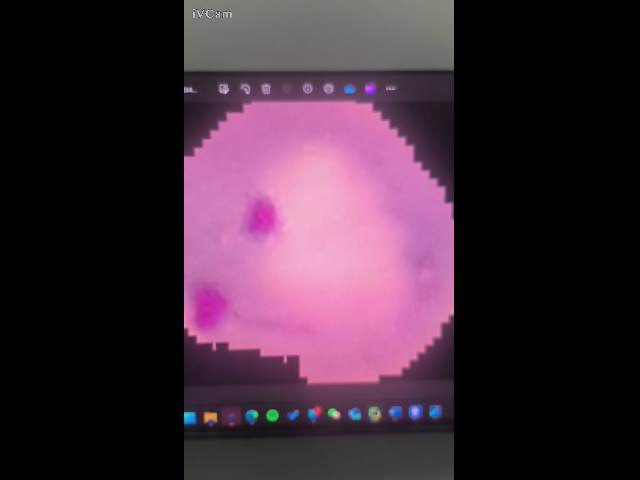

In [25]:
img_pil

### 预处理

In [26]:
input_img = test_transform(img_pil)
input_tensor = input_img.unsqueeze(0).numpy()

### ONNX Runtime预测

In [27]:
# onnx runtime 输入
ort_inputs = {'input': input_tensor}

# onnx runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

In [28]:
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [29]:
pred_softmax.shape

torch.Size([1, 2])

### 解析top-n预测结果的类别和置信度

In [30]:
n = 2
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

### 在图像上写中文

In [56]:
draw = ImageDraw.Draw(img_pil) 
# 在图像上写字
for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
img = np.array(img_pil) # PIL 转 array

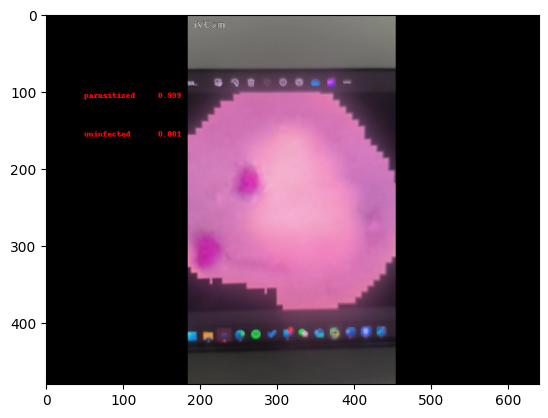

In [57]:
plt.imshow(img)
plt.show()

## 处理单帧画面的函数（中文）

In [33]:
# 处理帧函数
def process_frame(img):
    
    '''
    输入摄像头拍摄画面bgr-array，输出图像分类预测结果bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    ## 画面转成 RGB 的 Pillow 格式
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL

    ## 预处理
    input_img = test_transform(img_pil) # 预处理
    input_tensor = input_img.unsqueeze(0).numpy()
    
    ## onnx runtime 预测
    ort_inputs = {'input': input_tensor} # onnx runtime 输入
    pred_logits = ort_session.run(['output'], ort_inputs)[0] # onnx runtime 输出
    pred_logits = torch.tensor(pred_logits)
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
    
    ## 解析top-n预测结果的类别和置信度
    n = 2
    top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度
    
    ## 在图像上写中文
    draw = ImageDraw.Draw(img_pil) 
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
        # 文字坐标，中文字符串，字体，rgba颜色
        draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
    img = np.array(img_pil) # PIL 转 array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # RGB转BGR
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)  
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img = cv2.putText(img, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)
    return img

## 调用摄像头获取每帧（模板）

In [34]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    # 获取画面
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    ## !!!处理帧函数
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

### 按键盘上的`q`键退出

## 视频逐帧处理（模板）

In [54]:
import cv2
import numpy as np
import time
from tqdm import tqdm

# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义process_frame函数即可
# 同济子豪兄 2021-7-10

def generate_video(input_path='videos/robot.mp4'):
    filehead = input_path.split('/')[-1]
    output_path = r"E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\7-ONNX Runtime图像分类部署\2-ONNX Runtime本地终端部署\【B】ONNX Runtime部署水果图像分类模型\4.mp4" 
    
    print('视频开始处理',input_path)
    
    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('视频总帧数为',frame_count)
    
    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    # 进度条绑定视频总帧数
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame)
                except:
                    print('报错！', error)
                    pass
                
                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                    # break
        except:
            print('中途中断')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('视频已保存', output_path)

In [46]:
generate_video(input_path=r"C:\Users\61640\Desktop\dfd940af463de505a753b052d9b0fc10.mp4")

视频开始处理 C:\Users\61640\Desktop\dfd940af463de505a753b052d9b0fc10.mp4
视频总帧数为 351


100%|██████████| 350/350 [00:13<00:00, 26.44it/s]

视频已保存 E:\MV-Code-202018010103-Lucy\main\Train_Custom_Dataset\图像分类\7-ONNX Runtime图像分类部署\2-ONNX Runtime本地终端部署\【B】ONNX Runtime部署水果图像分类模型\3.mp4
